# PhageHostLearn: data processing

In this notebook, all the necessary data processing steps are completed in order to run PhageHostLearn models with RBPs and bacterial K-loci. The notebook transforms collections of phage genomes and bacterial genomes to collections of RBPs and loci.

## Libraries & files

In [2]:
import re
import os
import json
import math
import subprocess
import numpy as np
import pandas as pd
import processing_utils as pu
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Seq import Seq
from tqdm.notebook import tqdm
from os import listdir
from xgboost import XGBClassifier

In [3]:
valencia_dir = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data' # general directory
data_suffix = 'Valencia' # choose a suffix for the created data files

## Phage genome processing w/ Phanotate

In the block below, set the correct directory and the path/location for Phanotate. The phage genomes directory should be a folder with all genomes present in them as separate FASTA files.

In [3]:
phage_genomes_dir = valencia_dir+'/phages_genomes'
phanotate_loc = '/opt/homebrew/Caskroom/miniforge/base/envs/ML1/bin/phanotate.py'

#### Phanotate

In [87]:
phage_files = listdir(phage_genomes_dir)
phage_files.remove('.DS_Store')
#record = SeqIO.read(phages_dir+'/'+phage_files[0], 'fasta')
bar = tqdm(total=len(phage_files), position=0, leave=True)
name_list = []; gene_list = []; gene_ids = []

for file in phage_files:
    count = 1
    # access PHANOTATE
    file_dir = phage_genomes_dir+'/'+file
    raw_str = phanotate_loc + ' ' + file_dir
    process = subprocess.Popen(raw_str, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    stdout, stderr = process.communicate()
    std_splits = stdout.split(sep=b'\n')
    std_splits = std_splits[2:] #std_splits.pop(0)
    
    # Save and reload TSV
    temp_tab = open(valencia_dir+'/phage_results.tsv', 'wb')
    for split in std_splits:
        split = split.replace(b',', b'') # replace commas for pandas compatibility
        temp_tab.write(split + b'\n')
    temp_tab.close()
    results_orfs = pd.read_csv(valencia_dir+'/phage_results.tsv', sep='\t', lineterminator='\n', index_col=False)
    
    # fill up lists accordingly
    name = file.split('.fasta')[0]
    sequence = str(SeqIO.read(file_dir, 'fasta').seq)
    for j, strand in enumerate(results_orfs['FRAME']):
        start = results_orfs['#START'][j]
        stop = results_orfs['STOP'][j]
        
        if strand == '+':
            gene = sequence[start-1:stop]
        else:
            sequence_part = sequence[stop-1:start]
            gene = str(Seq(sequence_part).reverse_complement())
            
        name_list.append(name)
        gene_list.append(gene)
        gene_ids.append(name+'_gp'+str(count))
        count = count + 1
        
    # update progress
    bar.update(1)
bar.close()
os.remove(valencia_dir+'/phage_results.tsv')

  0%|          | 0/102 [00:00<?, ?it/s]

In [89]:
# Export final genes database
genebase = pd.DataFrame(list(zip(name_list, gene_ids, gene_list)), columns=['phage_ID', 'gene_ID', 'gene_sequence'])
genebase.to_csv(valencia_dir+'/phage_genes'+data_suffix+'.csv', index=False)

#### RBP detection w/ PhageRBPdetection

In the blocks below, we detect RBP sequences from the previously identified genes, with the PhageRBPdetection tool, more specifically with its combined [embeddings + HMM-scores] XGBoost model. For this, language embeddings are needed, see the 'RBPdetect_protein_embessings' notebook in the PhageRBPdetection notebook.

In the code block below, provide the correct paths to the Pfam file, the trained XGB model, the saved phage genes, and protein embeddings of them.

In [4]:
pfam_file = '/Users/dimi/Documents/GitHub/PhageHostLearning/processing/RBPdetect_phageRBPs.hmm'
xgb_model_combined = '/Users/dimi/Documents/GitHub/PhageHostLearning/processing/RBPdetect_xgb_hmm.json'
genebase = pd.read_csv(valencia_dir+'/phage_genes'+data_suffix+'.csv')
hmmer_path = '/Users/Dimi/hmmer-3.3.1' # e.g. '/Users/Sally/hmmer-3.3.1'
embeddings_file = valencia_dir+'/phage_proteins'+data_suffix+'_embeddings.csv' # e.g. 'data/embeddings.csv'

In [5]:
# define all the blocks we want scores for
new_blocks = ['Phage_T7_tail', 'Tail_spike_N', 'Prophage_tail', 'BppU_N', 'Mtd_N', 
           'Head_binding', 'DUF3751', 'End_N_terminal', 'phage_tail_N', 'Prophage_tailD1', 
           'DUF2163', 'Phage_fiber_2', 'unknown_N0', 'unknown_N1', 'unknown_N2', 'unknown_N3', 'unknown_N4', 
            'unknown_N6', 'unknown_N10', 'unknown_N11', 'unknown_N12', 'unknown_N13', 'unknown_N17', 'unknown_N19', 
            'unknown_N23', 'unknown_N24', 'unknown_N26','unknown_N29', 'unknown_N36', 'unknown_N45', 'unknown_N48', 
            'unknown_N49', 'unknown_N53', 'unknown_N57', 'unknown_N60', 'unknown_N61', 'unknown_N65', 'unknown_N73', 
            'unknown_N82', 'unknown_N83', 'unknown_N101', 'unknown_N114', 'unknown_N119', 'unknown_N122', 
            'unknown_N163', 'unknown_N174', 'unknown_N192', 'unknown_N200', 'unknown_N206', 'unknown_N208', 
            'Lipase_GDSL_2', 'Pectate_lyase_3', 'gp37_C', 'Beta_helix', 'Gp58', 'End_beta_propel', 
            'End_tail_spike', 'End_beta_barrel', 'PhageP22-tail', 'Phage_spike_2', 
            'gp12-short_mid', 'Collar', 
            'unknown_C2', 'unknown_C3', 'unknown_C8', 'unknown_C15', 'unknown_C35', 'unknown_C54', 'unknown_C76', 
            'unknown_C100', 'unknown_C105', 'unknown_C112', 'unknown_C123', 'unknown_C179', 'unknown_C201', 
            'unknown_C203', 'unknown_C228', 'unknown_C234', 'unknown_C242', 'unknown_C258', 'unknown_C262', 
            'unknown_C267', 'unknown_C268', 'unknown_C274', 'unknown_C286', 'unknown_C292', 'unknown_C294', 
            'Peptidase_S74', 'Phage_fiber_C', 'S_tail_recep_bd', 'CBM_4_9', 'DUF1983', 'DUF3672']

In [11]:
# optionally press database first if not done already
output, err = pu.hmmpress_python(hmmer_path, pfam_file)

In [13]:
# get domains & scores
phage_genes = genebase['gene_sequence']
phage_ids = genebase['phage_ID']

hmm_scores = {item:[0]*len(phage_genes) for item in new_blocks}
bar = tqdm(total=len(phage_genes), desc='Scanning the genes', position=0, leave=True)
for i, sequence in enumerate(phage_genes):
    hits, scores, biases, ranges = pu.gene_domain_scan(hmmer_path, pfam_file, [sequence])
    for j, dom in enumerate(hits):
        hmm_scores[dom][i] = scores[j]
    bar.update(1)
bar.close()
hmm_scores_array = np.asarray(pd.DataFrame(hmm_scores))

Scanning the genes:   0%|          | 0/9505 [00:00<?, ?it/s]

In [16]:
# load protein embeddings to make predictions for and concat them with the HMM scores
embeddings_df = pd.read_csv(embeddings_file)
embeddings = np.asarray(embeddings_df.iloc[:, 1:])
features = np.concatenate((embeddings, hmm_scores_array), axis=1)

# load trained model
xgb_saved = XGBClassifier()
xgb_saved.load_model(xgb_model_combined)

# make predictions with the XGBoost model
score_xgb = xgb_saved.predict_proba(features)[:,1]
preds_xgb = (score_xgb > 0.5)*1

In [19]:
# construct RBPbase with all the information
RBPbase = {'phage_ID':[], 'protein_ID':[], 'protein_sequence':[], 'dna_sequence':[], 
           'xgb_score':[]}

for i, dna_sequence in enumerate(genebase['gene_sequence']):
    if preds_xgb[i] == 1:
        RBPbase['phage_ID'].append(genebase['phage_ID'][i])
        RBPbase['protein_ID'].append(genebase['gene_ID'][i])
        RBPbase['protein_sequence'].append(str(Seq(dna_sequence).translate())[:-1])
        RBPbase['dna_sequence'].append(dna_sequence)
        RBPbase['xgb_score'].append(score_xgb[i])
RBPbase = pd.DataFrame(RBPbase)

#### Filter for length & save dataframe

In [21]:
to_delete = [i for i, protein_seq in enumerate(RBPbase['protein_sequence']) if (len(protein_seq)<200 or len(protein_seq)>1500)]
RBPbase = RBPbase.drop(to_delete)
RBPbase = RBPbase.reset_index(drop=True)

In [ ]:
# Load previous version of RBPbase and add only new ones, keeping naming of already existing ones consistent
# for further data processing (structure prediction)
...

In [24]:
RBPbase.to_csv(valencia_dir+'/RBPbase'+data_suffix+'.csv', index=False)

#### CD-HIT for 3D structure predictions

**!! before running this again, copy the white list as we have manually added RBPs there -> can't be overwritten;**
**although the naming has changed anyway so...**

Here, we cluster the identified RBPs to see how they cluster together. Subsequently, the representative of each of the clusters is subjected to AlphaFold's 3D structure prediction (on high-performance computing infrastructure).

Let's keep it simple: all the already known RBPs (with B-helix) that are representatives are white listed by default (and subsequently all the sequences in those clusters), and all other representatives are subjected to a 3D structure prediction for manual check of B-helix presence. The representatives are automatically generated in a fasta file as output of the clustering. The representatives can then be subjected to 3D structure prediction (manual step on HPC). If the B-helix is present, we write the protein name in the white list file (manually), and subsequently run the code under 'Interaction matrix construction' again to keep all the sequences in the corresponding clusters.

## Bacterial genome processing

#### Set file paths

In [3]:
bacterial_genomes_dir = valencia_dir+'/klebsiella_genomes/fasta_files'
database_path = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/klebsiella_RBP_data/Klebsiella_k_locus_primary_reference.gbk'
kaptive_directory = '/Users/dimi/Documents/GitHub/PhageHostLearning/processing'

#### Construct dataframe (optional)

#### Run Kaptive

In [4]:
Locibase, seros = pu.compute_kaptive_from_directory(kaptive_directory, database_path, bacterial_genomes_dir, valencia_dir)
pd.DataFrame(seros, columns=['sero']).to_csv(valencia_dir+'/serotypes'+data_suffix+'.csv', index=False)
dict_file = open(valencia_dir+'/Locibase'+data_suffix+'.json', 'w')
json.dump(Locibase, dict_file)
dict_file.close()

100%|███████████████████████████████████████████████████████████████████████████████████| 62/62 [1:40:26<00:00, 97.21s/it]


In [5]:
# doublecheck
dict_file = open(valencia_dir+'/Locibase'+data_suffix+'.json')
loci_dictionary = json.load(dict_file)

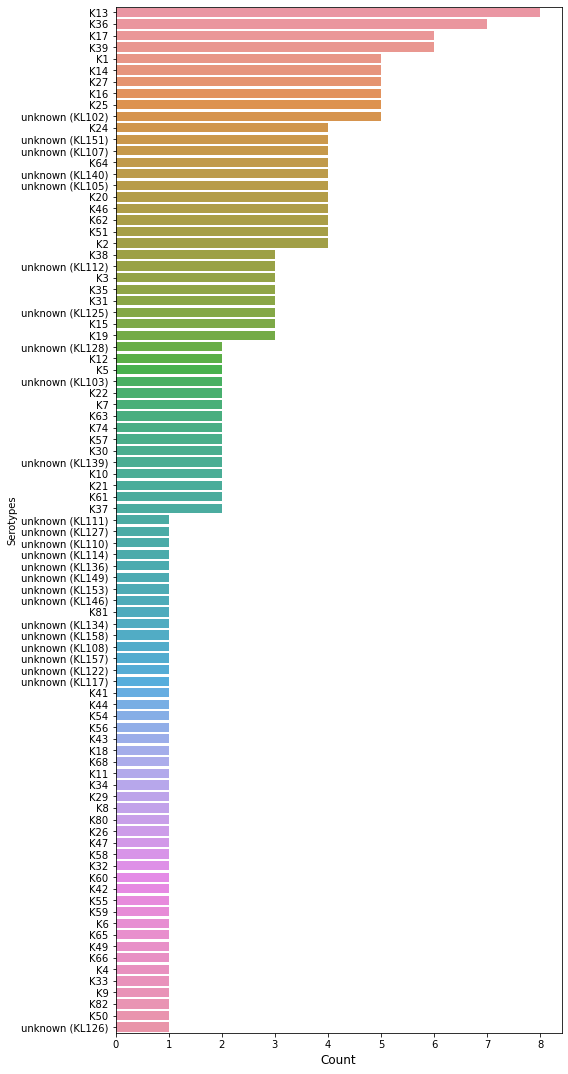

In [17]:
# Serotype bar plot
import seaborn as sns
old_seros = pd.read_csv(valencia_dir+'/serotypes'+data_suffix+'.csv')
fig, ax = plt.subplots(figsize=(8,15))
bacteria_counts = old_seros['sero'].value_counts()
sns.barplot(y=bacteria_counts.index, x=bacteria_counts.values, ax=ax, orient='h')
ax.set_xlabel('Count', size=12)
ax.set_ylabel('Serotypes')
results_path = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/Kloci_exploration'
fig.savefig(results_path+'/serotypes_barplot.svg', format='svg', dpi=400)
fig.tight_layout()
fig.savefig(results_path+'/serotypes_barplot.png', dpi=400)

In [5]:
old_seros

,sero
0,K41
1,K15
2,K14
3,K43
4,K74
...,...
195,unknown (KL139)
196,K1
197,K1
198,unknown (KL102)


## Interaction matrix construction

In this section, we construct and filter (refine) the interaction matrix. The interaction matrix is the third and final piece of information we need in order to construct machine learning models later. Basically, the interaction matrix contains the labels, which are now displayed as a matrix as we are dealing with pairs of objects.

Practically, it seems most likely that the (initial) interaction matrix is constructed at the phage-bacterium level (not at the RBP-locus level). If new data is added at a later timepoint, we need to be able to add that to the existing database and save a new version of it.

The second step is that this matrix can be reworked to the level of RBPs-receptors for machine learning models that work at the singleRBP level. Afterwards, it can be filtered further based on the white listed RBPs that contain a B-helix (see above). The columns of the initial interaction matrix should correspond with the phage names in the constructed RBPbase earlier, which corresponds with the names of the fasta files in the phage genomes directory. Same for the bacterial names. In the end, we want the interaction matrix to correspond (in rows and columns) to the RBPbase and Locibase!

Below, the initial interaction matrix is an MS Excel file that was put together based on experimental results.

#### Construct interaction matrix from initial file (run again if new RBPs are detected, genomes are added or new RBPs are white listed)

In [3]:
# make initial database
file = valencia_dir+'/klebsiella_phage_host_interactions.xlsx'
output = valencia_dir+'/phage_host_interactions'+data_suffix
pu.xlsx_database_to_csv(file, output)

In [4]:
# add part 2 of the database
new_file = valencia_dir+'/klebsiella_interactions_part2.xlsx'
pu.add_to_database(output+'.csv', new_file, output)

In [5]:
new_database = pd.read_csv(output+'.csv', index_col=0)
new_database

,K1PH164C1,K1lambda5,K2PH164C1,K2PH164C2,K2alfa62,K3PH164,K4PH164,K5lamda5,K6PH25C3,K7PH164C2,...,S8c,S9a,S10a,S11a,S13a,S13b,S13c,S13d,S13e,S13f
ERS739095,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
K2,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sampleK3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sampleK4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ERS812516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HGV2C_06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HGV2C_08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CU371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42KP-HG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Delete identical interactions (run again if new RBPs are detected, genomes are added or new RBPs are white listed)

In [5]:
pwjulia_directory = '/Users/dimi/Documents/GitHub/PhageHostLearning'
RBPbase = pd.read_csv(valencia_dir+'/RBPbase'+data_suffix+'.csv')

In [19]:
# compute RBP similarities (run only if new RBPs are detected or genomes are added)
fasta_temp = open(valencia_dir+'/RBPbase'+data_suffix+'.fasta', 'w')
for i, sequence in enumerate(RBPbase['ProteinSeq']):
    name = RBPbase['unique_ID'][i]
    fasta_temp.write('>'+name+'\n'+sequence+'\n')
fasta_temp.close()
pu.pairwise_alignment_julia(valencia_dir+'/RBPbase'+data_suffix+'.fasta', 'protein', pwjulia_directory)

(b'\rProgress:   0%|                                         |  ETA: 0:28:17\x1b[K\rProgress:  26%|\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x8b                              |  ETA: 0:00:06\x1b[K\rProgress:  30%|\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x8d                            |  ETA: 0:00:05\x1b[K\rProgress:  33%|\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x8b                           |  ETA: 0:00:04\x1b[K\rProgress:  36%|\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88                          |  ETA: 0:00:04\x1b[K\rProgress:  40%|\x

In [9]:
# compute loci similarities (run only if new RBPs are detected or genomes are added)
pu.pairwise_alignment_julia(valencia_dir+'/kaptive_results_all_loci.fasta', 'DNA', pwjulia_directory)

(b'\rProgress:   0%|                                         |  ETA: 1:46:46\x1b[K\rProgress:   0%|\xe2\x96\x8f                                        |  ETA: 1:25:14\x1b[K\rProgress:   1%|\xe2\x96\x8e                                        |  ETA: 0:55:06\x1b[K\rProgress:   1%|\xe2\x96\x8d                                        |  ETA: 1:11:20\x1b[K\rProgress:   1%|\xe2\x96\x8d                                        |  ETA: 1:14:36\x1b[K\rProgress:   1%|\xe2\x96\x8d                                        |  ETA: 1:13:15\x1b[K\rProgress:   1%|\xe2\x96\x8d                                        |  ETA: 1:15:39\x1b[K\rProgress:   1%|\xe2\x96\x8c                                        |  ETA: 1:17:26\x1b[K\rProgress:   1%|\xe2\x96\x8c                                        |  ETA: 1:19:26\x1b[K\rProgress:   1%|\xe2\x96\x8c                                        |  ETA: 1:20:54\x1b[K\rProgress:   1%|\xe2\x96\x8c                                        |  ETA: 1:19:20\x1b[K\rProgress:   1%|\

In [6]:
# adjust interaction matrix
loci_sim = np.loadtxt(valencia_dir+'/kaptive_results_all_loci.fasta_score_matrix.txt')
rbp_sim = np.loadtxt(valencia_dir+'/RBPbaseValencia.fasta_score_matrix.txt')
IM = pd.read_csv(valencia_dir+'/interactions'+data_suffix+'.csv', index_col=0)
interactions = np.asarray(IM)

# delete identical interactions
for i in range(rbp_sim.shape[0]-1):
    for j in range(i, rbp_sim.shape[0]):
        if (rbp_sim[i,j] == 1) and (i != j):
            # get the corresponding loci
            locus_i = list(np.where(interactions[:, i] == 1)[0])
            locus_j = list(np.where(interactions[:, j] == 1)[0])
            
            for li in locus_i:
                for lj in locus_j:
                    if loci_sim[li, lj] == 1: # if identical delete one of both
                        interactions[lj,j] = np.nan

# save new interaction matrix
row_names = IM.index; column_names = IM.columns
IM_no_identicals = pd.DataFrame(interactions, index=row_names, columns=column_names)
IM_no_identicals.to_csv(valencia_dir+'/interactions'+data_suffix+'.csv')

#### Filter for white listed RBPs (run again if new RBPs are detected, genomes are added or new RBPs are white listed)

#### filter for mono-RBP phages (run again if new RBPs are detected, genomes are added or new RBPs are white listed)